# Libraries

In [77]:
import pickle
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import random
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


## Extraction des données

- X représente les données des 6 variables sur la longeur de l'enregistrement
- Y représente les labels associés

In [78]:
with open('./Data/X', 'rb') as outfile:
    X = pickle.load(outfile)
with open('./Data/Y', 'rb') as outfile:
    Y = pickle.load(outfile)


# Dataset
- Représentation graphique
- Analyse du set

## Représentation graphique
 - Tracé aléatoire d'exemple du dataset
 - Permet de visualiser les données en fonction des labels

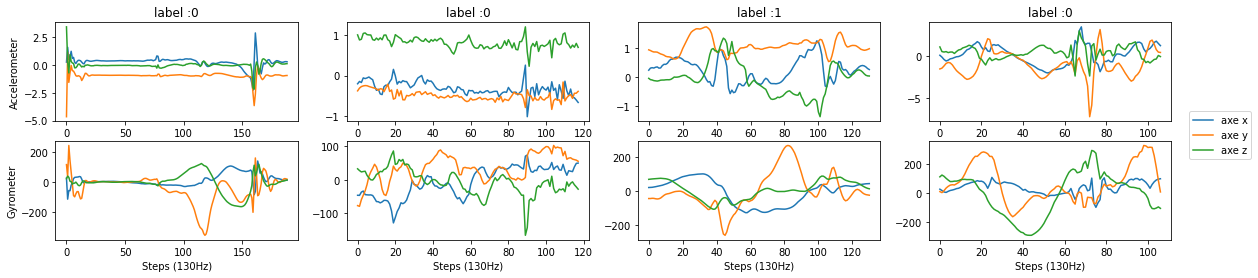

In [79]:
# Choix des années à plot
I = [random.randint(0, 6315) for _ in range(4)]

# Plot des 4 années selectionnées
fig, axs = plt.subplots(2, len(I), figsize=(20, 4))

for index, value in enumerate(I):
    data = X[value]
    label = Y[value]
    axs[0, index].set_title("label :" + str(label))
    for count, axe in enumerate(['axe x', 'axe y', 'axe z']):
        axs[0, index].plot(data[count, :], label=axe)
        axs[1, index].plot(data[count+3, :], label=axe)
        axs[1, index].set_xlabel("Steps (130Hz)")
axs[0, 0].set_ylabel("Accelerometer")
axs[1, 0].set_ylabel("Gyrometer")
plt.legend(bbox_to_anchor=(1.05, 1.35))
plt.savefig("./Rapport/Annexes/Trace_aleatoire.png",dpi=100)
plt.show()


## Analyse du set
- Représentation de la répartition des données selon la durée et leurs labels
- Analyse de la présence d'outlier

In [80]:
# fonction retournant les éléments triés du plus petit au plus grand pour le graphique en barres
def chrono_bar_chart(list_like):
    counter = Counter(list_like)
    x_bar = sorted(counter, key=None, reverse=False)
    y_bar = [counter[x] for x in x_bar]
    return x_bar, y_bar

def longest_shortest_10(x_bar,y_bar,label):
    # Aperçu des enregistrement les plus cours
    print(f"\n\nlabel :{label}")
    print("10 durées d'enregistrements les plus courtes : (qtité x steps)")
    for i in range(10):
        print(y_bar[i], "x ", x_bar[i], "s", sep="", end=" ")

    # Aperçu des enregistrement les plus longs    
    print("\n\n10 durées d'enregistrements les plus longues : (qtité x steps)")
    for i in range(1,11)[::-1]:
        print(y_bar[-i], "x ", x_bar[-i], "s", sep="", end=" ")
    

In [81]:
# Vérification des données avec celles indiqués dans l'énnoncé
print("longueur du dataset :", len(X))

longueur du dataset : 6316


In [82]:
# Analyse des différentes longueurs d'enregistrement en fonction du label
label_0 = [x.shape[1] for x, y in zip(X, Y) if y == 0]
label_1 = [x.shape[1] for x, y in zip(X, Y) if y == 1]



label :0
10 durées d'enregistrements les plus courtes : (qtité x steps)
1x 14s 1x 15s 1x 16s 1x 18s 2x 20s 1x 23s 1x 24s 1x 28s 2x 29s 5x 30s 

10 durées d'enregistrements les plus longues : (qtité x steps)
3x 390s 2x 391s 4x 392s 1x 396s 1x 398s 2x 404s 1x 429s 1x 437s 1x 499s 1x 514s 
label :1
10 durées d'enregistrements les plus courtes : (qtité x steps)
1x 40s 1x 41s 2x 42s 2x 46s 1x 48s 1x 49s 1x 50s 2x 54s 3x 56s 1x 57s 

10 durées d'enregistrements les plus longues : (qtité x steps)
1x 264s 1x 265s 1x 266s 2x 267s 1x 275s 1x 276s 1x 289s 1x 290s 1x 300s 1x 343s 

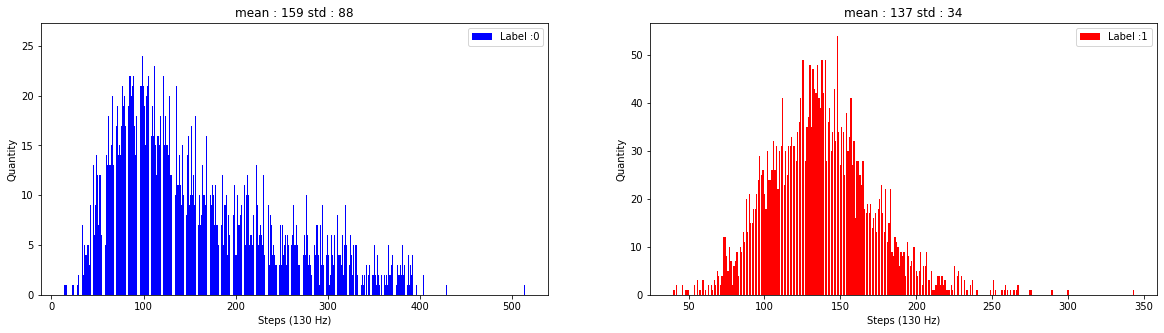

In [83]:
# Graphique en barres des différentes longueurs d'enregistrement en fonction du label
labels = [label_0, label_1]
colors = ['blue', 'red']
fig, ax = plt.subplots(figsize=(20, 5))
for index, (label, color) in enumerate(zip(labels, colors)):
    x_bar, y_bar = chrono_bar_chart(label)
    longest_shortest_10(x_bar,y_bar,index)
    mean, std = round(np.mean(label)), round(np.std(label))
    plt.subplot(1, 2, index+1)
    plt.bar(x_bar, y_bar, color=color, label="Label :"+str(index))
    plt.title(f"mean : {mean} std : {std}")
    plt.ylabel("Quantity")
    plt.xlabel("Steps (130 Hz)")
    plt.legend()
plt.savefig("./Rapport/Annexes/graphique_barres_durees_enregistrements.png",dpi=100)
plt.show()


# Création des jeux de données
Création des jeux d'entraînement, de validation et de test
- En utilisant le principe de la fenêtre glissante et un pas de temps en paramètre
- En mélangeant l'ensemble des fenêtres précédement crées
- En séparant les données en 3 jeux selon des ratios
- En générant des batchs pour les jeux d'entraînement et de validation

Permet d'obtenir une entrée fixe pour le traitement via le réseau de neurones, ainsi que d'augmenter la quantité de donnée à notre disposition.

## Fenêtrage des données

In [84]:
# On glisse avec le pas de temps défini, seuls les enregistrements supérieurs au pas de temps et inférieur à 340 sont gardés
def fenetrage(steps, X, Y):
    data_X, data_Y = [], []
    for x, y in zip(X, Y):
        # D'après l'analyse du set, les données au dessus de 340 steps ne permettent pas d'identifer les mouvements, de plus cette sélection permet une meilleure répartition des labels
        if x.shape[1] > steps and x.shape[1] < 344:
            windows = np.lib.stride_tricks.sliding_window_view(x, (6, steps))[
                0]
            for window in windows:
                data_X.append(window)
                data_Y.append(y)
    nb_data = len(data_X)
    assert nb_data == len(data_Y)
    perc_0 = 100*Counter(data_Y)[0]/nb_data
    perc_1 = 100*Counter(data_Y)[1]/nb_data
    print(
        f"Equilibre : {round(perc_0,1)}% label 0 et {round(perc_1,1)}% label 1")
    print(f"Total de données : {nb_data}")
    return data_X, data_Y


## Mélange

In [85]:
# Fonction pour mélanger les données et les labels de la même manière
def shuffle_initial_set(data_X, data_Y):
    temp = list(zip(data_X, data_Y))
    random.seed(111)
    random.shuffle(temp)
    shuffled_X, shuffled_Y = zip(*temp)
    return shuffled_X, shuffled_Y


## Séparation des jeux

In [86]:
# Fonction pour séparer les données mélangées selon des ratios qui sont prédéfinis
def set_split_train_valid_test(shuffled_X, shuffled_Y, train_ratio=0.7, validation_ratio=0.15, test_ratio=0.15):
    x_train, x_test, y_train, y_test = train_test_split(
        shuffled_X, shuffled_Y, test_size=1 - train_ratio)
    x_val, x_test, y_val, y_test = train_test_split(
        x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio))
    return x_train, y_train, x_val, y_val, x_test, y_test


## Génération de batch
L'objectif de la fonction suivante et de créer des batchs qui seront utilisés lors de l'entraînement, un de ses paramètres est le nombre de division souhaitée


In [87]:
def batch_generation(X_train_data, Y_train_data, X_val_data, Y_val_data, batch_divide, device):
    X_train_batch_size = int(len(X_train_data)/batch_divide)+1
    X_val_batch_size = int(len(X_val_data)/batch_divide)+1
    
    X_train_batchs = torch.Tensor(X_train_data).split(X_train_batch_size)
    Y_train_batchs = torch.Tensor(Y_train_data).split(X_train_batch_size)
    X_train_batchs = [X_batch.to(device) for X_batch in X_train_batchs]
    Y_train_batchs = [Y_batch.reshape(Y_batch.shape[0],1).to(device) for Y_batch in Y_train_batchs]
    
    X_val_batchs = torch.Tensor(X_val_data).split(X_val_batch_size)
    Y_val_batchs = torch.Tensor(Y_val_data).split(X_val_batch_size)
    X_val_batchs = [X_batch.to(device) for X_batch in X_val_batchs]
    Y_val_batchs = [Y_batch.reshape(Y_batch.shape[0],1).to(device) for Y_batch in Y_val_batchs]
    
    return X_train_batchs, Y_train_batchs, X_val_batchs, Y_val_batchs

## Jeux de données

In [88]:
# Largeur de la fenêtre
steps = 30

data_X, data_Y = fenetrage(steps, X, Y)
shuffled_X, shuffled_Y = shuffle_initial_set(data_X, data_Y)
X_train, Y_train, X_val, Y_val, X_test, Y_test = set_split_train_valid_test(
    shuffled_X, shuffled_Y)
X_train_batchs, Y_train_batchs, X_val_batchs, Y_val_batchs = batch_generation(
    X_train, Y_train, X_val, Y_val, 100, device)


Equilibre : 50.6% label 0 et 49.4% label 1
Total de données : 706204


# Création du réseau
L'objectif est de mettre en place un réseau neuronale qui va inférer les données précédement construites, afin d'en extraire des features puis une prédiction de label.

Le modèle mis en place dans ces travaux, est un modèle basé sur l'architecture des réseaux de convolutifs combinés avec du pooling.

## Construction de la classe

In [89]:
class Convolutive_Architecture (nn.Module):
    """
    Extaction des features de la fenêtre d'enregistrement donnée en entrée
    et prédiction du label
    """

    def __init__(self):
        """
        """
        super(Convolutive_Architecture, self).__init__()

        # Couches distinctes de normalisation du batch pour les données
        # d'accélération et de vitesse angulaire
        self.acc_to_BN_acc = nn.LazyBatchNorm1d()
        self.gyr_to_BN_gyr = nn.LazyBatchNorm1d()

        # Couches distinctes de convolution pour les données d'accélération
        # et de vitesse angulaire
        self.BN_acc_to_conv1 = nn.Conv1d(3, 16, 4)
        self.BN_gyr_to_conv1 = nn.Conv1d(3, 16, 4)

        # Secondes couches, également distinctes, de convolution pour les données
        # d'accélération et de vitesse angulaire
        self.acc_conv1_to_conv2 = nn.Conv1d(16, 32, 4)
        self.gyr_conv1_to_conv2 = nn.Conv1d(16, 32, 4)

        # Troisième et dernière couche de convolution, appliquée à la matrice de
        # features de l'accélération et de vitesses angulaires fusionnées
        self.acc_gyr_conv2_to_conv3 = nn.Conv1d(32, 64, 4)

        # Ensemble de couches complétements connectées pour traitées les features
        # extraites par les couches convolutives
        self.features_to_fc1 = nn.LazyLinear(128)
        self.fc1_to_fc2 = nn.Linear(128, 128)
        self.fc2_to_prediction = nn.Linear(128, 1)

        # Ensemble de couches d'activations
        self.maxpool = nn.MaxPool1d(3, stride=2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.flatten = nn.Flatten()

    def forward(self, tensor_data):
        """
        """
        # Séparations des données en fonction des unités de mesures
        acc, gyr = torch.split(tensor_data, 3, dim=1)

        # Normalisations par batch des sous-ensembles précédements créés
        BN_acc = self.acc_to_BN_acc(acc)
        BN_gyr = self.gyr_to_BN_gyr(gyr)

        # Application des premières couches de convolutions sur les sous-ensembles normalisées,
        # suivi d'une couche de maxpooling, et d'une activation ReLu
        acc_conv1 = self.relu(self.maxpool(self.BN_acc_to_conv1(BN_acc)))
        gyr_conv1 = self.relu(self.maxpool(self.BN_gyr_to_conv1(BN_gyr)))

        # Application des secondes couches de convolutions sur les 2 sous-ensembles,
        # suivi d'une couche de maxpooling, et d'une activation ReLu
        acc_conv2 = self.relu(self.maxpool(self.acc_conv1_to_conv2(acc_conv1)))
        gyr_conv2 = self.relu(self.maxpool(self.gyr_conv1_to_conv2(gyr_conv1)))

        # Fusion des features en une seule matrice
        fusionned_sub_features = torch.cat((acc_conv2, gyr_conv2), dim=2)

        # Application de la dernière couche de convolution sur la matrice de features fusionnée
        # suivi d'une couche de maxpooling, et d'une activation ReLu
        acc_gyr_conv3 = self.relu(self.maxpool(
            self.acc_gyr_conv2_to_conv3(fusionned_sub_features)))

        # Redimensionnement de la matrice des features pour son traitement suivant
        features = self.flatten(acc_gyr_conv3)

        # Application successive de 2 couches complétement connectées suivi
        # d'une activation non linéaires
        fc1 = self.relu(self.features_to_fc1(features))
        fc2 = self.relu(self.fc1_to_fc2(fc1))

        # Application de la couche de sortie, avec une activation sigmoïd
        prediction = self.sigmoid(self.fc2_to_prediction(fc2))

        return features, prediction


## Fonctions
- Calcul de la précision de prédiction du modèle


In [90]:
def get_accuracy(y_true,y_pred):
    y_pred_tag = torch.round(y_pred)

    correct_results_sum = (y_pred_tag == y_true).sum().float()
    acc = correct_results_sum/y_true.shape[0]
    acc = round(acc.item() * 100,1)
    
    return acc

## Initialisation

In [91]:
# Initialisation du modèle
model = Convolutive_Architecture()
model.to(device)

# Etablissement du critère de calcul de la fonction loss : Entropie croisée binaire
criterion = nn.BCELoss()

# Choix de l'opitmiseur
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Nombre d'epochs
epochs = 90

# Listes d'accumulation des résultats de loss et de précision
train_losses, validation_losses = [], []
train_accuracies, validation_accuracies = [], []

# Mis en condition d'entraînement pour le réseau
model.train()


C:\Users\YLK\miniconda3\envs\TDK\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Convolutive_Architecture(
  (acc_to_BN_acc): LazyBatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gyr_to_BN_gyr): LazyBatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BN_acc_to_conv1): Conv1d(3, 16, kernel_size=(4,), stride=(1,))
  (BN_gyr_to_conv1): Conv1d(3, 16, kernel_size=(4,), stride=(1,))
  (acc_conv1_to_conv2): Conv1d(16, 32, kernel_size=(4,), stride=(1,))
  (gyr_conv1_to_conv2): Conv1d(16, 32, kernel_size=(4,), stride=(1,))
  (acc_gyr_conv2_to_conv3): Conv1d(32, 64, kernel_size=(4,), stride=(1,))
  (features_to_fc1): LazyLinear(in_features=0, out_features=128, bias=True)
  (fc1_to_fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc2_to_prediction): Linear(in_features=128, out_features=1, bias=True)
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

## Entraînement

In [92]:
# Entraînement du modèle
for epoch in range(epochs):
    for X_train_batch, Y_train_batch, X_val_batch, Y_val_batch in zip(X_train_batchs, Y_train_batchs, X_val_batchs, Y_val_batchs):

        # Retour du réseau
        features, Y_train_pred = model.forward(X_train_batch)

        # Calcul de la fonction loss, et ajout de cette valeur dans la liste correspondante
        train_loss = criterion(Y_train_pred, Y_train_batch)
        train_losses.append(train_loss.item())

        # Calcul de la précision du modèle, et ajout de cette valeur dans la liste correspondante
        train_accuracy = get_accuracy(Y_train_batch, Y_train_pred)
        train_accuracies.append(train_accuracy)

        # Même procédé avec les données de validation
        with torch.no_grad():
            # Retour réseau
            features, Y_val_pred = model.forward(X_val_batch)

            # Calcul de la loss
            val_loss = criterion(Y_val_pred, Y_val_batch)
            validation_losses.append(val_loss.item())

            # Calcul de la précision
            val_accuracy = get_accuracy(Y_val_batch, Y_val_pred)
            validation_accuracies.append(val_accuracy)

        # Remise à zero de l'optimiseur
        optimizer.zero_grad()
        # Calcul du gradient
        train_loss.backward()
        # Ajustement des paramètres
        optimizer.step()

    print(f"epochs: {epoch+1}/{epochs}, train loss: {train_loss.item()}, train acc: {train_accuracy}, val loss: {val_loss.item()}, val acc: {val_accuracy}")


epochs: 1/90, train loss: 0.390531450510025, train acc: 82.7, val loss: 0.3770822286605835, val acc: 83.4
epochs: 2/90, train loss: 0.35599273443222046, train acc: 83.9, val loss: 0.3480454981327057, val acc: 85.2
epochs: 3/90, train loss: 0.3185175359249115, train acc: 86.4, val loss: 0.3183276057243347, val acc: 86.2
epochs: 4/90, train loss: 0.3010522723197937, train acc: 87.2, val loss: 0.2940613925457001, val acc: 87.2
epochs: 5/90, train loss: 0.28136375546455383, train acc: 88.1, val loss: 0.26978737115859985, val acc: 87.9
epochs: 6/90, train loss: 0.2689237892627716, train acc: 88.1, val loss: 0.26451289653778076, val acc: 88.7
epochs: 7/90, train loss: 0.25716087222099304, train acc: 88.5, val loss: 0.25283125042915344, val acc: 89.5
epochs: 8/90, train loss: 0.25132811069488525, train acc: 89.0, val loss: 0.2646291255950928, val acc: 88.4
epochs: 9/90, train loss: 0.24048785865306854, train acc: 89.2, val loss: 0.24573764204978943, val acc: 88.8
epochs: 10/90, train loss: 0.

## Sauvegarde
- Enregistrement des paramètres du modèle
- Enregistrements des listes des loss et des précisions

In [93]:
# Sauvegarde du modèle dans un dossier nommer par la largeur de la fenêtre
if not os.path.exists(os.path.join("./Backup",f"Steps={steps}/")):
    os.makedirs(os.path.join("./Backup",f"Steps={steps}/"))
    os.makedirs(os.path.join("./Backup",f"Steps={steps}/Plots/"))
    os.makedirs(os.path.join("./Backup",f"Steps={steps}/Confusion_Matrix/"))

# Ensemble des sauvegardes                
torch.save(model, f"./Backup/Steps={steps}/Convolutive_Architecture.pt")
np.save(f'./Backup/Steps={steps}/Plots/train_losses.npy', train_losses)
np.save(f'./Backup/Steps={steps}/Plots/validation_losses.npy', validation_losses)
np.save(f'./Backup/Steps={steps}/Plots/train_accuracies.npy', train_accuracies)
np.save(f'./Backup/Steps={steps}/Plots/validation_accuracies.npy', validation_accuracies)

# Evaluation du modèle
- Graphiques des évolutions des loss et de la précision sur les données d'entraînements et de validation
- Matrice de confusion et précision des modèles sur chaque jeux de données

## Tracé

### loss
- Le graphique représente la moyenne glissante de 50 itérations

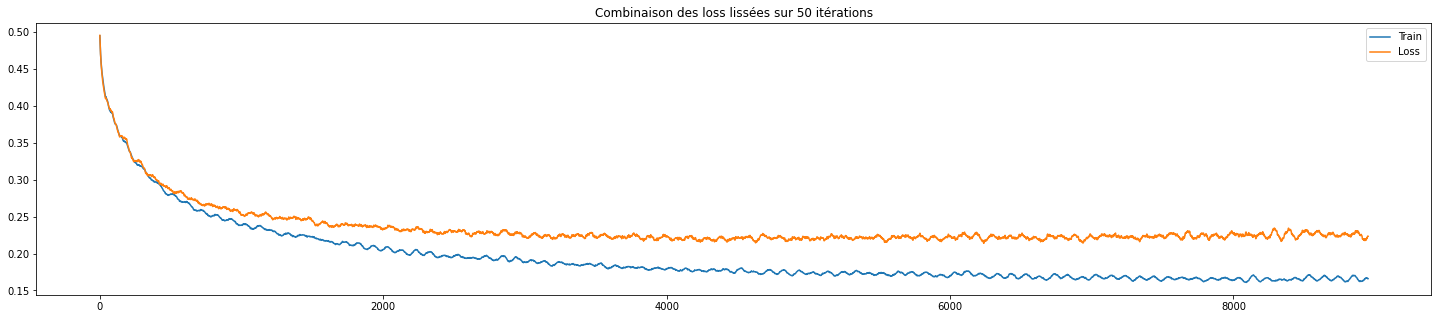

In [94]:
# Chargement de données enregistrées
train_losses = np.load(f'./Backup/Steps={steps}/Plots/train_losses.npy')
validation_losses = np.load(f'./Backup/Steps={steps}/Plots/validation_losses.npy')

# Calcul de la moyenne glissante
kernel_size = 50
kernel = np.ones(kernel_size) / kernel_size
train_losses_means=np.convolve(train_losses,kernel, mode='valid')
validation_losses_means=np.convolve(validation_losses,kernel, mode='valid')

# Graphique des courbes lissées
fig, ax = plt.subplots(figsize=(25, 5))
plt.plot(train_losses_means, label="Train")
plt.plot(validation_losses_means, label="Loss")
plt.legend()
plt.title("Combinaison des loss lissées sur 50 itérations")
plt.savefig(f'./Backup/Steps={steps}/Plots/plot_losses.png',dpi=100)
plt.show()

### précisions
- Le graphique représente la moyenne glissante de 50 itérations

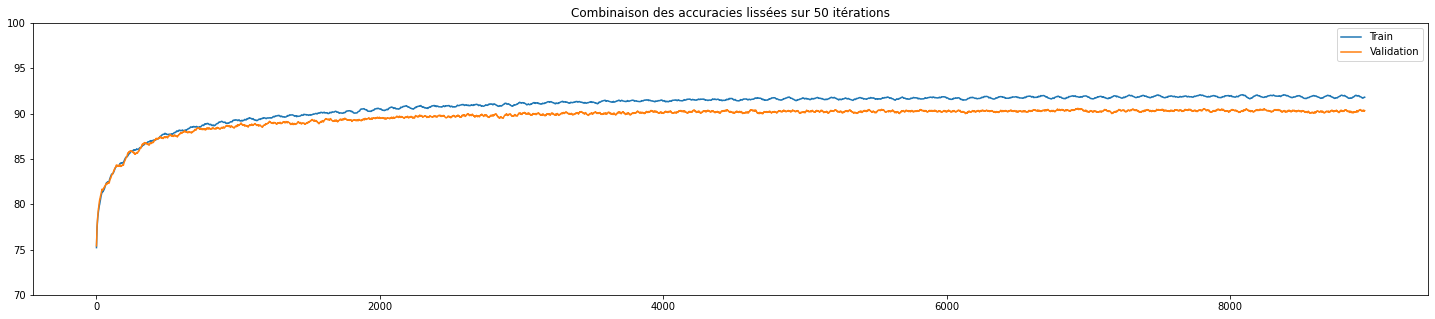

In [95]:
# Chargement de données enregistrées
train_accuracies = np.load(f'./Backup/Steps={steps}/Plots/train_accuracies.npy')
validation_accuracies = np.load(f'./Backup/Steps={steps}/Plots/validation_accuracies.npy')

# Calcul de la moyenne glissante
kernel_size = 50
kernel = np.ones(kernel_size) / kernel_size
train_accuracies_means=np.convolve(train_accuracies,kernel, mode='valid')
validation_accuracies_means=np.convolve(validation_accuracies,kernel, mode='valid')

# Graphique des courbes lissées
fig, ax = plt.subplots(figsize=(25, 5))
plt.plot(train_accuracies_means, label="Train")
plt.plot(validation_accuracies_means, label="Validation")
plt.ylim([70,100])
plt.legend()
plt.title("Combinaison des accuracies lissées sur 50 itérations")
plt.savefig(f'./Backup/Steps={steps}/Plots/plot_accuracies.png',dpi=100)
plt.show()

## Performances
- Visualisation des matrices de confusions pour chacun des jeux de données
- Précision du modèle pour chacun des jeux de données

In [96]:
# Chargement du modèle
model = torch.load(f"./Backup/Steps={steps}/Convolutive_Architecture.pt")
model.to('cpu')

# Mise en condition d'évaluation
model.eval()

Convolutive_Architecture(
  (acc_to_BN_acc): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gyr_to_BN_gyr): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BN_acc_to_conv1): Conv1d(3, 16, kernel_size=(4,), stride=(1,))
  (BN_gyr_to_conv1): Conv1d(3, 16, kernel_size=(4,), stride=(1,))
  (acc_conv1_to_conv2): Conv1d(16, 32, kernel_size=(4,), stride=(1,))
  (gyr_conv1_to_conv2): Conv1d(16, 32, kernel_size=(4,), stride=(1,))
  (acc_gyr_conv2_to_conv3): Conv1d(32, 64, kernel_size=(4,), stride=(1,))
  (features_to_fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc1_to_fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc2_to_prediction): Linear(in_features=128, out_features=1, bias=True)
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

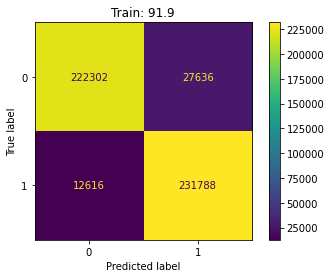

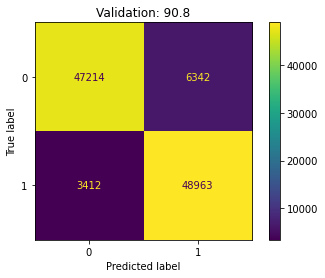

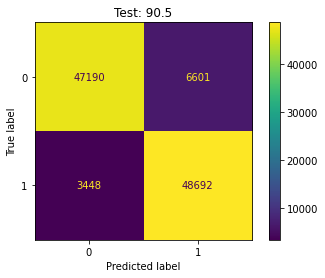

In [97]:
# Prétraitement pour la boucle
categories = ['Train', 'Validation', 'Test']
X_data = [X_train, X_val, X_test]
Y_data = [Y_train, Y_val, Y_test]

# Tracé des matrice de confusion pour chaque dataset
for category, X, Y in zip(categories, X_data, Y_data):
    X_tensor = torch.Tensor(X).to('cpu')
    features, Y_pred = model.forward(X_tensor)
    Y_pred = torch.round(Y_pred).detach().numpy()
    cm = confusion_matrix(Y, Y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    accuracy = round(100*accuracy_score(Y, Y_pred),1)
    plt.title(f"{category}: {accuracy}")
    plt.savefig(f"./Backup/Steps={steps}/Confusion_Matrix/{category}_confusion_matrix.png", dpi=100)
    plt.show()

# Temps de calcul modèle
- Evaluation du temps nécéssaire pour obtenir une production du modèle

In [98]:
test = torch.Tensor([X_test[0]])


In [99]:
%%timeit
model.forward(test)

602 µs ± 20.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
